In [72]:
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, presetCubeViews, bytesToPic, bytesToPic2,
         croppedPic, colorInRange, imgToColors, pointsToList,
         roiSelectZoomWindow, roiSelectScoreWindow, subprocBatchOutput,
         exploreImgs, buildImgComparisonData)

from modules.EvalHelpers import EvalTracker, EvalDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial Data Viewing

In [9]:
# standard gs loading script
db_name = "../data/misc/books/eval-data-2/large_dataset.db"
db = DBInterface(db_name)
listGS = [ pickle.loads(d[1]) for d in db.selectAll()]

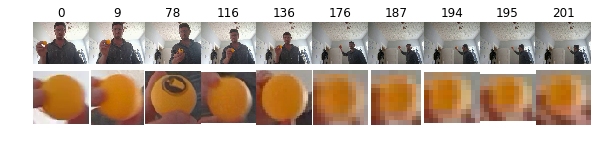

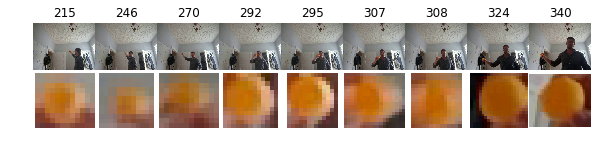

In [15]:
exploreImgs(listGS[:10], figw=10)
exploreImgs(listGS[10:], figw=10)

In [16]:
# initialize needed objects
tracker = TrackFactory(on=True)
tracker.setInit(ballColor = "orange")
tracker.setAlgoEnum(1)

In [54]:
# full data, in display form
evData = EvalDataset()
evData.buildDataset(listGS, tracker)
evData.getDatasetDisplay()

,list Index,frame Counter,check Both Contains Other,distance From Baseline,check Track Success,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii
0,0,0,True,2,True,True,True,True,False,6
1,1,9,True,7,True,True,True,True,False,7
2,2,78,True,1,True,True,True,True,False,-1
3,3,116,True,4,True,True,True,True,False,3
4,4,136,True,4,True,True,True,True,False,2
5,5,176,True,5,True,True,True,True,False,0
6,6,187,False,5,True,False,False,False,False,-1
7,7,194,False,6,True,False,False,False,False,-2
8,8,195,False,4,True,False,False,False,False,-1
9,9,201,False,4,True,False,False,False,False,-3


### Filtering

In [43]:
# filtering
condition_1 = (
               (df.checkBothContainsOther == False) & 
               (df.checkEitherContainsOther == True)
              )

evData.setRowsRequested(condition_1)
evData.getDatasetDisplay()

,list Index,frame Counter,check Both Contains Other,distance From Baseline,check Track Success,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii
12,12,270,False,3,True,False,True,True,False,-3
17,17,324,False,7,True,False,True,True,False,-2


In [70]:
frame_inds = evData.getFilteredIndex( condition_1
                                     ,return_index='frameCounter'
                                    )
frame_inds

[270, 324]

In [71]:
# get the dataset for just the particular filtered
vid_fn = "data/proc/tmp/dec14/output5.proc1.proc1.avi"

specific_records = subprocBatchOutput(
                              f_pathfn = vid_fn
                             ,batch_list = frame_inds
                             )

[_gs.frameCounter for _gs in specific_records]

[270, 324]

### Calc'd Fields / Aggregation

In [181]:
from modules.EvalHelpers import EvalDataset, EvalTracker

In [182]:
evData = EvalDataset()

In [183]:
evData.buildDataset(listGS,tracker)

In [184]:
evData.buildProps(listGS)

In [185]:
evData.df_props[:4]

,propBaselineRadius
0,26
1,26
2,25
3,19


In [186]:
evData.buildCalcs()

In [187]:
evData.df_calcs[:4]

,calc_BallUnitsAway
0,0.043001
1,0.138675
2,0.028284
3,0.117688


In [188]:
evData.getFullDataset()

,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline,frameCounter,listIndex,propBaselineRadius,calc_BallUnitsAway
0,True,True,True,True,False,True,6,2.236068,0,0,26,0.043001
1,True,True,True,True,False,True,7,7.211103,9,1,26,0.138675
2,True,True,True,True,False,True,-1,1.414214,78,2,25,0.028284
3,True,True,True,True,False,True,3,4.472136,116,3,19,0.117688
4,True,True,True,True,False,True,2,4.123106,136,4,15,0.137437
5,True,True,True,True,False,True,0,5.385165,176,5,6,0.448764
6,False,False,False,False,False,True,-1,5.385165,187,6,4,0.673146
7,False,False,False,False,False,True,-2,6.000000,194,7,4,0.750000
8,False,False,False,False,False,True,-1,4.000000,195,8,4,0.500000
9,False,False,False,False,False,True,-3,4.123106,201,9,4,0.515388


### Demo Diagnostics

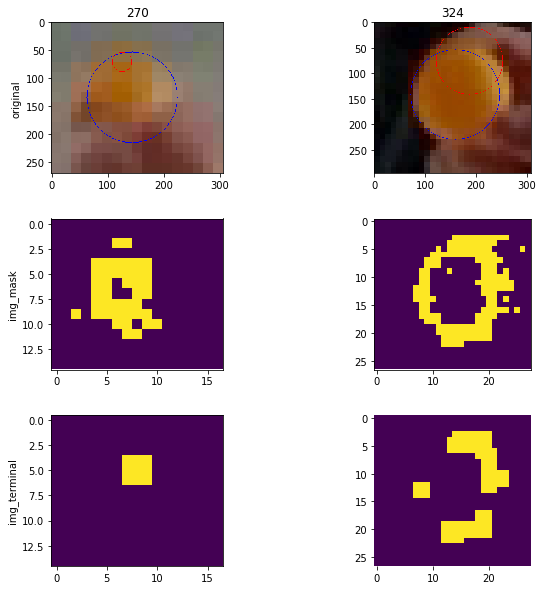

In [79]:
# diagnostic1
chart_data = buildImgComparisonData(specific_records, tracker)
multiPlot(chart_data
          ,input_transform_titles = ['original', 'img_mask', 'img_terminal']
          ,input_frame_titles = map(str, frame_inds)
         )

In [77]:
track_thresh = [
     tracker.getTrackParams()['thresh_lo']
    ,tracker.getTrackParams()['thresh_hi']
]
track_thresh

[(6, 30, 120), (64, 255, 255)]

In [84]:
pcm = buildConfusionData(specific_records[0]
                         ,[track_thresh]
                         ,bOutputScore = False)

pcm2 = buildConfusionData(specific_records[1]
                         ,[track_thresh]
                         ,bOutputScore = False)

In [87]:
pcm.displayVals(bN = True)
pcm2.displayVals(bN = True)

                                         True          False
                        307200             49         307151
       Positive             82             31             51
       Negative         307118         307100             18
                                         True          False
                        307200            197         307003
       Positive            195             91            104
       Negative         307005         306899            106


In [88]:
views1 = presetCubeViews()
view1 = views1[0][1]
print view1

{'elevation': 95, 'azimuth': -81}


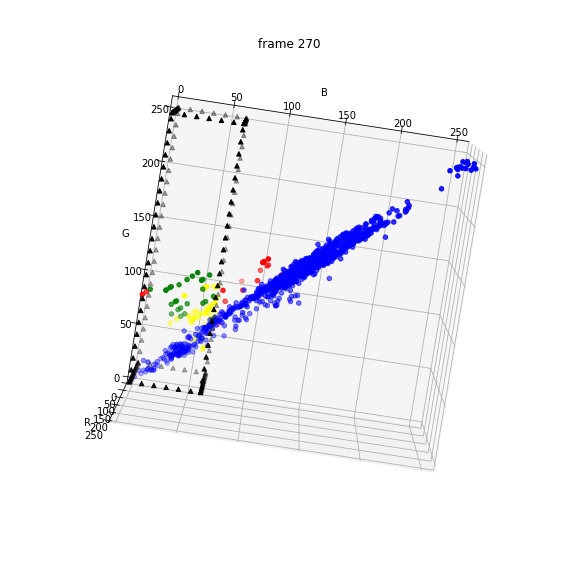

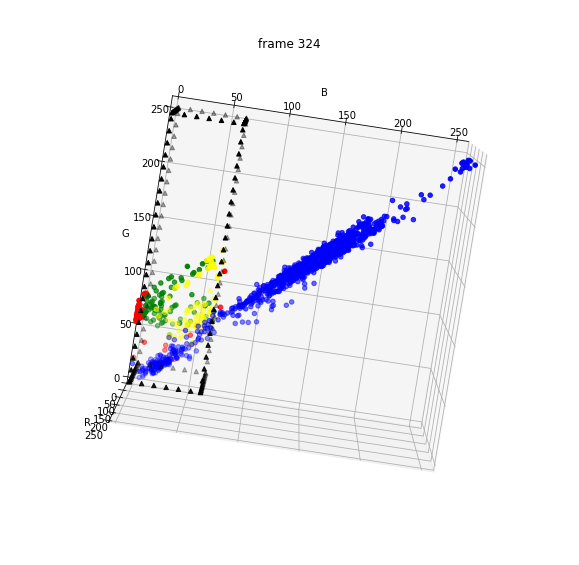

In [90]:
confusionPlotByImage( listGS = specific_records
                     ,inputThresh = track_thresh
                     ,viewPositionDefined = view1
                     ,bOutputScore = False
                    )